# Inverting evolution for Ising model
The goal is to obtain the inverse evolution: $e^{-itH}\to e^{itH}$

In [1]:
from simple_exact_diagonalization_routines.local_matrix_class import *
from scipy.linalg import expm
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
from class_ising_model import *
import itertools
from class_double_bracket_flow import *
import math

## Nearest-neighbor

### Test 1: 1D Nearest neighbor
First, we observe that for a nearest-neighbor model $H_{NN} = \sum_i Z_i Z_{i+1}$, $X_{odd} = \prod_i X_{2i-1}$, satisfies:

   \begin{align}
        X_\text{odd} H_\text{NN}X_\text{odd} =-H_\text{NN}
    \end{align}

In the 4 qubit case:

$H_{NN} = Z_1 Z_2 + Z_2 Z_3 + Z_3 Z_4$

$H_{odd} = X_1X_3$

$H_{odd}H_{NN}H_{odd} = -Z_1Z_2 - Z_2Z_3 - Z_3Z_4$

In [60]:
# Test: class output correct Hamiltonian, J_class = '1D' by default
# # H_NN = Z1Z2 + Z2Z3 + Z3Z4

sys_1D = ising_model([0,0,0,0],[0,0,0,0])
print(np.all(sys_1D.H == sys_1D.Z.at(1) @ sys_1D.Z.at(2) + sys_1D.Z.at(2) @ sys_1D.Z.at(3) + sys_1D.Z.at(3) @ sys_1D.Z.at(4)))

True


In [63]:
X_odd_list = [sys_1D.X.at(2*i + 1) for i in range(math.ceil(sys_1D.L/2))]
X_odd = np.linalg.multi_dot(X_odd_list)
print(np.all(X_odd == sys_1D.X.at(1)@sys_1D.X.at(3)))
print(np.all(X_odd @ sys_1D.H @ X_odd ==-sys_1D.H))

True
True


### Test 2: Circular NN (Even L)
$H_{NN} = Z_1 Z_2 + Z_2 Z_3 + Z_3 Z_4 + Z_4Z_1$

$H_{odd} = X_1X_3$

$H_{odd}H_{NN}H_{odd} = -Z_1Z_2 - Z_2Z_3 - Z_3Z_4 - Z_4Z_1$

In [64]:
# Test: class output correct Hamiltonian, J_class = 'custom' and 'circular'
# # H_NN = Z1Z2 + Z2Z3 + Z3Z4 + Z4Z1

# sys = ising_model([0,0,0],[0,0,0],J_type='custom',J_custom={(1,2):1, (2,3):1, (1,3):1})
sys_circ = ising_model([0,0,0,0],[0,0,0,0],J_type='circular')
print(np.all(sys_circ.H == sys_circ.Z.at(1) @ sys_circ.Z.at(2) + sys_circ.Z.at(2) @ sys_circ.Z.at(3) + sys_circ.Z.at(3) @ sys_circ.Z.at(4) + sys_circ.Z.at(1) @ sys_circ.Z.at(4)))

True


In [67]:
print(np.all(X_odd == sys_circ.X.at(1)@sys_circ.X.at(3)))
print(np.all(X_odd @ sys_circ.H @ X_odd ==-sys_circ.H))

True
True


## Next-nearest-neighbor

### Test 1: 1D NNN
$H_{NNN} = Z_1 Z_2 + .5Z_1 Z_3 + Z_2 Z_3 + .5Z_2 Z_4 + Z_3 Z_4$

$H_{odd} = X_1X_3$

$H_{odd}H_{NNN}H_{odd} = ...$


In [16]:
sys_1D = ising_model([0,0,0,0],[0,0,0,0],max_coupling_range=2)
print(np.all(sys_1D.H == sys_1D.Z.at(1) @ sys_1D.Z.at(2) + .5*sys_1D.Z.at(1) @ sys_1D.Z.at(3)\
    + sys_1D.Z.at(2) @ sys_1D.Z.at(3) + .5*sys_1D.Z.at(2) @ sys_1D.Z.at(4) + sys_1D.Z.at(3) @ sys_1D.Z.at(4)))
X_odd = sys_1D.X_odd()
X_cor = sys_1D.X.at(1) @ sys_1D.X.at(2)
print(np.all(X_odd @ sys_1D.H @ X_odd == sys_1D.H))
print(np.all(X_cor @ sys_1D.H @ X_cor == -sys_1D.H))

True
False
False


In [13]:
sys_1D = ising_model([0,0,0,0],[0,0,0,0],max_coupling_range=2)
print(np.all(sys_1D.H == sys_1D.Z.at(1) @ sys_1D.Z.at(3) + sys_1D.Z.at(2) @ sys_1D.Z.at(4)))
X_odd = sys_1D.X_odd()
X_cor = sys_1D.X.at(1) @ sys_1D.X.at(2)
print(np.all(X_odd @ sys_1D.H @ X_odd == sys_1D.H))
print(np.all(X_cor @ sys_1D.H @ X_cor == -sys_1D.H))

False
False
False


## H with field
$H  = Z_1Z_2 + \frac{1}{2}Z_1Z_3 + Z_2Z_3$

$H_{inverter} = X_2$

$H_{inverter} H H_{inverter} = -H + Z_1Z_3$

In [98]:
# Basic case
sys = ising_model([0,0,0], [0,0,0], max_coupling_range=2)
H_inverter = sys.X.at(2)
H_imp_inv = H_inverter @ sys.H @ H_inverter
print(np.all(H_imp_inv == (-sys.H + sys.Z.at(1)@sys.Z.at(3))))
print(np.all(H_imp_inv + sys.H == sys.Z.at(1)@sys.Z.at(3)))

True
True


### Convergence
$\lang e^{itH}, \mathcal I(e^{-itH})\rang = tr(e^{-itH} X_2e^{-itH}X_2e^{it Z_1Z_3})=tr(e^{-itH} e^{it(Z_1Z_2+Z_2 Z_3 - \frac{1}{2}Z_1Z_3)}e^{it Z_1Z_3})$

In [168]:
# Convergence
def convergence(H,H_inverter,t, N):
    H_imp_inv = H_inverter @ H @ H_inverter
    missing_term = H_imp_inv + H
    s = t/N
    target = expm(-1j*t*H) @ np.linalg.matrix_power(((H_inverter @ expm(-1j*s*H) @ H_inverter) @ expm(1j* s *missing_term)), N)
    return np.abs(target.trace()/np.sqrt(np.size(H)))

In [176]:
N_list = np.linspace(1,1001,21)
convergence_list = [convergence(sys.H, H_inverter, 1, int(N)) for N in N_list]
print(convergence_list)
# No clear trend

[1.0, 1.0000000000000002, 0.9999999999999974, 1.000000000000003, 0.9999999999999989, 1.0000000000000082, 0.99999999999999, 0.9999999999999764, 1.0000000000000249, 1.00000000000001, 1.0000000000000169, 0.9999999999999383, 1.0000000000000089, 0.9999999999999902, 0.9999999999999917, 1.0000000000000986, 1.0000000000000382, 0.9999999999999931, 1.0000000000000182, 0.999999999999982, 0.9999999999999825]


$H  = Z_1Z_2 + \frac{1}{2}Z_1Z_3 + Z_2Z_3 +Z_1 + Z_2 + Z_3 + 2(X_1 + X_2 + X_3)$

$H_{inverter} = Y_1Y_3$

$H_{inverter} H H_{inverter} = -H + Z_1Z_3+2Z_2+4X_2$

In [177]:
# D and B = [1,1,1]
sys = ising_model([1,1,1], [1,1,1], max_coupling_range=2)
H_inverter = sys.Y.at(1)@sys.Y.at(3)
H_imp_inv = H_inverter @ sys.H @ H_inverter
print(np.all(H_imp_inv == (-sys.H + sys.Z.at(1)@sys.Z.at(3)+2*sys.Z.at(2)+4*sys.X.at(2))))

True


[0.4208290181660961, 0.9001324857234819, 0.9692521506428866, 0.9853634271416382, 0.9914812835306365, 0.994435752407034, 0.9960832204084248, 0.9970944350527611, 0.9977592781350435, 0.9982195777882122, 0.9985513679934538, 0.9987983808813581, 0.9989872151941835, 0.9991348019968949, 0.9992523337046184, 0.9993474490838816, 0.999425505903673, 0.9994903519699658, 0.9995448083939625, 0.9995909815937039, 0.9996304700369318]


Text(0, 0.5, 'Convergence trace')

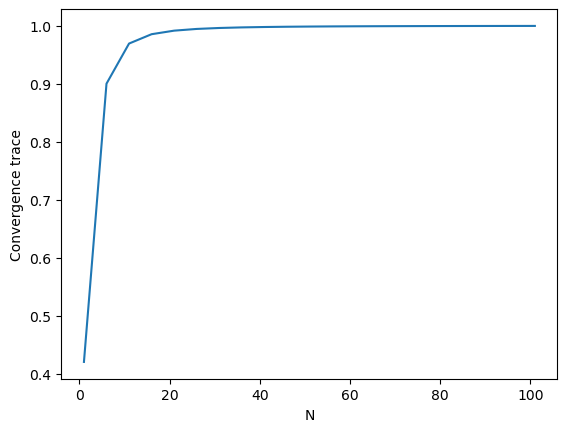

In [228]:
N_list = np.linspace(1,101,21)
convergence_list = [convergence(sys.H, H_inverter, 1, int(N)) for N in N_list]
print(convergence_list)
plt.plot(N_list, convergence_list)
plt.xlabel('N')
plt.ylabel('Convergence trace')

# DBI integration

## Test: group commutator approximation

### Without imperfect inversion
$e^{s[\hat D,\hat J]} = e^{i\sqrt s \hat D}e^{i\sqrt s\hat J}e^{-i\sqrt s \hat D}e^{-i\sqrt s\hat J}+ \hat E^{\text{(GC)}}$

In [181]:
# D and B = [1,1,1]
sys = ising_model([1,1,1], [1,1,1], max_coupling_range=2)
H_inverter = sys.Y.at(1)@sys.Y.at(3)
H_imp_inv = H_inverter @ sys.H @ H_inverter
print(np.all(H_imp_inv == (-sys.H + sys.Z.at(1)@sys.Z.at(3)+2*sys.Z.at(2)+4*sys.X.at(2))))

True


In [211]:
def commutator(A, B):
    return A.dot( B ) - B.dot( A )

def group_commutator(D , H, s):
    sqrt_s = np.sqrt(s)
    return expm(1j*sqrt_s*D) @ expm(1j*sqrt_s*H) @ expm(-1j*sqrt_s*D) @ expm(-1j*sqrt_s*H)

def delta( A ):
        return np.diag( A.diagonal() )

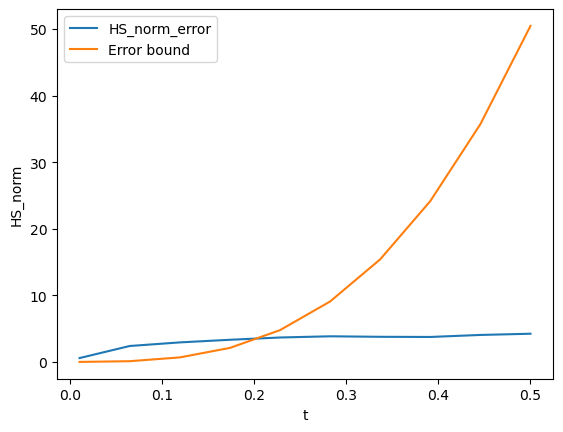

In [227]:
t_list = np.linspace(0.01, 0.5, 10)
norm_list = []
bound_list = []
D = delta(sys.H)
bound = np.linalg.norm(commutator(D, commutator(D, sys.H)))\
            + np.linalg.norm(commutator(sys.H, commutator(D, sys.H)))
for t in t_list:
    GC = group_commutator(D, sys.H, t)
    exp_commutator = expm(t * commutator(D, sys.H))
    diff = exp_commutator - GC
    HS_norm = np.linalg.norm(diff, 'fro')
    norm_list.append(HS_norm)
    bound_list.append(bound*(t**3))
plt.plot(t_list, norm_list,label='HS_norm_error')
plt.plot(t_list, bound_list, label='Error bound')
plt.xlabel('t')
plt.ylabel('HS_norm')
plt.legend()

In [203]:
GC

array([[ 6.96673182e-01+0.01878749j, -1.96523282e-03-0.33410081j,
         1.24219245e-01-0.4013209j ,  2.53221281e-02-0.10609654j,
        -1.96523282e-03-0.33410081j, -2.50904422e-01+0.14656998j,
         2.53221281e-02-0.10609654j, -3.05270065e-02-0.07339707j],
       [-1.83810832e-01-0.06034136j,  1.99819605e-01-0.15914661j,
        -1.26180174e-01+0.2688891j ,  2.18447718e-02-0.43678938j,
        -3.53457293e-01-0.26858702j, -5.01443795e-01-0.11987192j,
        -1.27976329e-02+0.38826054j,  5.45370637e-02+0.03258095j],
       [ 5.88114663e-01-0.11868171j,  1.32696324e-01+0.34267991j,
        -1.87385636e-01+0.52557086j,  3.94150460e-03-0.03228847j,
         1.32696324e-01+0.34267991j, -2.02461907e-01+0.05052899j,
         3.94150460e-03-0.03228847j,  4.52068799e-02+0.10449018j],
       [-1.66566924e-01+0.07235487j,  2.16338558e-01-0.41105594j,
        -3.29201071e-01-0.08527051j,  3.88621304e-01-0.24563702j,
         2.50980963e-01+0.41399398j, -6.36728899e-02+0.33852273j,
       

In [208]:
exp_commutator

array([[-0.03521464,  0.40701838,  0.77336966, -0.05493629,  0.40701838,
         0.21512915, -0.05493629, -0.13044091],
       [-0.40701838,  0.10749973,  0.04230416,  0.63391413, -0.30058233,
         0.41093055, -0.27903112,  0.28648047],
       [-0.77336966,  0.04230416, -0.08740947, -0.05290825,  0.04230416,
        -0.32134619, -0.05290825, -0.53086507],
       [-0.05493629, -0.63391413,  0.05290825, -0.22760097,  0.27903112,
         0.24143485, -0.63568303, -0.0170683 ],
       [-0.40701838, -0.30058233,  0.04230416, -0.27903112,  0.10749973,
         0.41093055,  0.63391413,  0.28648047],
       [ 0.21512915, -0.41093055,  0.32134619,  0.24143485, -0.41093055,
         0.1954964 ,  0.24143485, -0.59827069],
       [-0.05493629,  0.27903112,  0.05290825, -0.63568303, -0.63391413,
         0.24143485, -0.22760097, -0.0170683 ],
       [ 0.13044091,  0.28648047, -0.53086507,  0.0170683 ,  0.28648047,
         0.59827069,  0.0170683 , -0.42251017]])

### With imperfect inversion